# Exploratory Data Analysis

In [848]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Visualization

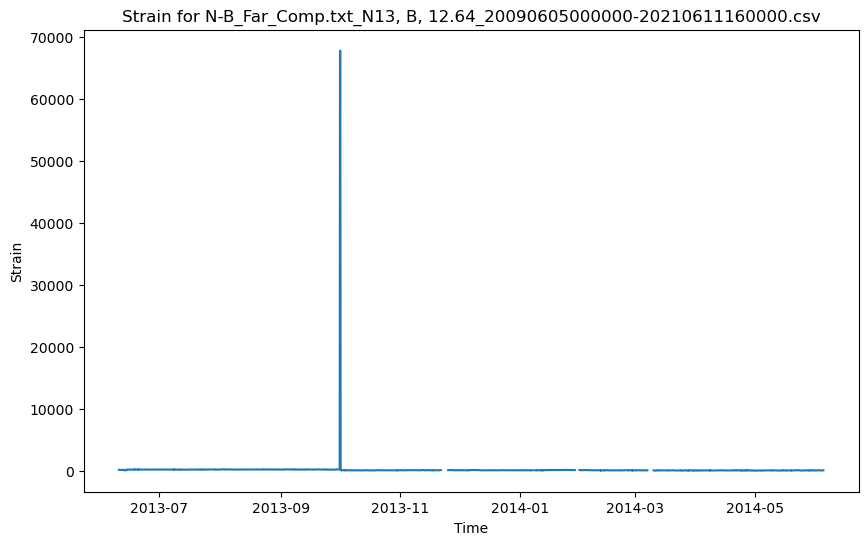

In [849]:
#Visualize the raw data

folder = '../timeseries_csv/' #main folder
file = 'N-B_Far_Comp.txt_N13, B, 12.64_20090605000000-20210611160000.csv' #file name

df = pd.read_csv(folder + file, parse_dates=['Time'])

#Customized start and end time
#Choose start and end time (start '2009-06-05 00:00:00', end '2021-06-11 16:00:00')
start_time = '2013-06-05 00:00:00'
end_time = '2014-06-05 00:00:00'

df = df[(df['Time'] >= start_time) & (df['Time'] <= end_time)]


plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Strain'], linestyle='-')
plt.xlabel('Time')
plt.ylabel('Strain')
plt.title(f'Strain for {file}')
plt.show()

          Time_index                Time  Strain
9809  20140424080000 2014-04-24 08:00:00     0.0
9810  20140424120000 2014-04-24 12:00:00     0.0


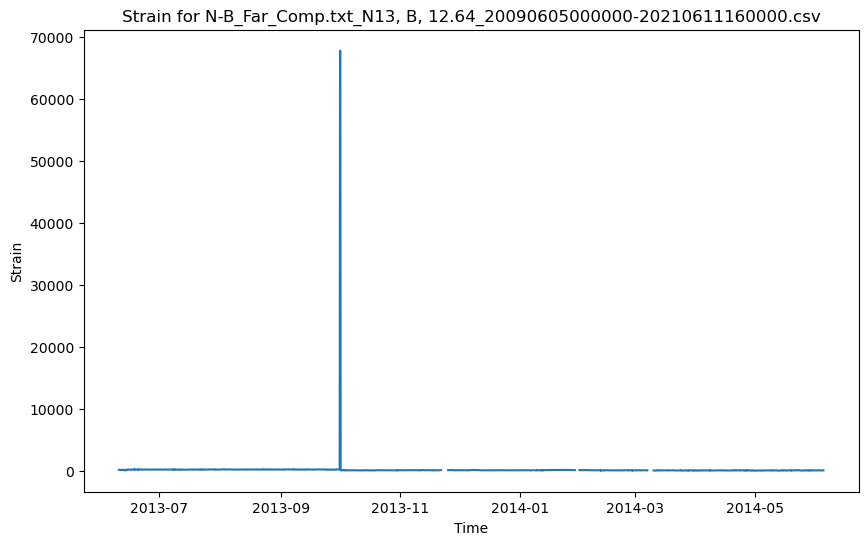

In [850]:
#Find values of strain that are exactly zero and remove them
df_zero = df[df["Strain"] == 0]
print(df_zero)

#Remove rows with strain values of zero and plot
indices_to_remove = df_zero.index
df = df.drop(index=indices_to_remove)
plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Strain'], linestyle='-')
plt.xlabel('Time')
plt.ylabel('Strain')
plt.title(f'Strain for {file}')
plt.show()

### Outliers

Lower bound = -120.5 Extreme lower bound = -299.0
Upper bound = 355.5 Extreme upper bound = 534.0


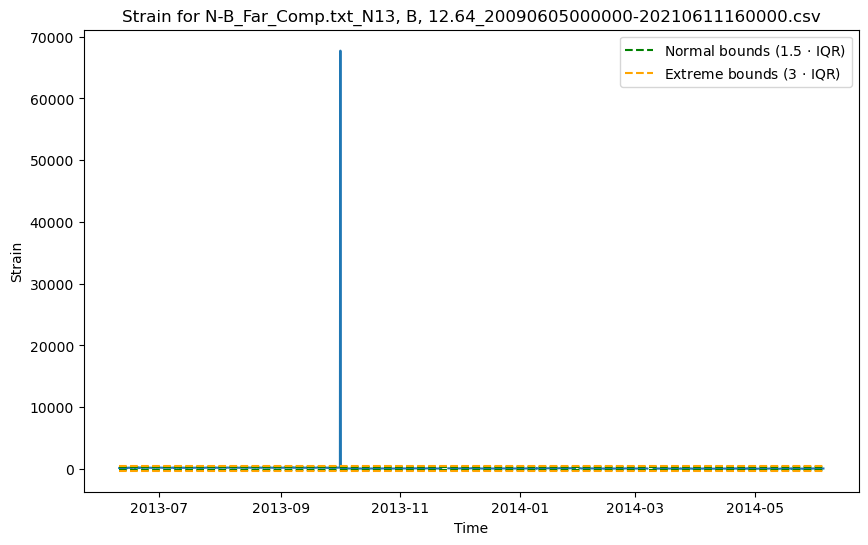

In [851]:
# Compute IQR
Q1 = df['Strain'].quantile(0.25)  # 25th percentile
Q3 = df['Strain'].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1

# Define bounds for extreme outliers
lower_bound = Q1 - 1.5 * IQR
lower_bound_extreme = Q1 - 3 * IQR
upper_bound = Q3 + 1.5 * IQR
upper_bound_extreme = Q3 + 3 * IQR
print(f'Lower bound = {lower_bound} Extreme lower bound = {lower_bound_extreme}')
print(f'Upper bound = {upper_bound} Extreme upper bound = {upper_bound_extreme}')


plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Strain'], linestyle='-')
plt.xlabel('Time')
plt.ylabel('Strain')
plt.title(f'Strain for {file}')
plt.hlines(y=[lower_bound, upper_bound], xmin=df['Time'].iloc[0], xmax=df['Time'].iloc[-1], 
           colors='green', linestyles='dashed', label=r'Normal bounds (1.5 $\cdot$ IQR)')
plt.hlines(y=[lower_bound_extreme, upper_bound_extreme], xmin=df['Time'].iloc[0], xmax=df['Time'].iloc[-1], 
           colors='orange', linestyles='dashed', label=r'Extreme bounds (3 $\cdot$ IQR)')
plt.legend()
plt.show()

In [852]:
mild_outliers = df[(df['Strain'] < lower_bound) | (df['Strain'] > upper_bound)]
mild_outlier_indices = mild_outliers.index  # Save the indices of mild outliers
num_mild_outliers = mild_outliers.shape[0]

# Count extreme outliers (outside 3 * IQR)
extreme_outliers = df[(df['Strain'] < lower_bound_extreme) | (df['Strain'] > upper_bound_extreme)]
extreme_outlier_indices = extreme_outliers.index  # Save the indices of extreme outliers
num_extreme_outliers = extreme_outliers.shape[0]

# Print results
print(f'Number of mild outliers (1.5 × IQR): {num_mild_outliers}')
print(f'Number of extreme outliers (3 × IQR): {num_extreme_outliers}')


Number of mild outliers (1.5 × IQR): 2
Number of extreme outliers (3 × IQR): 2


Number of outliers replaced with NaN: 2


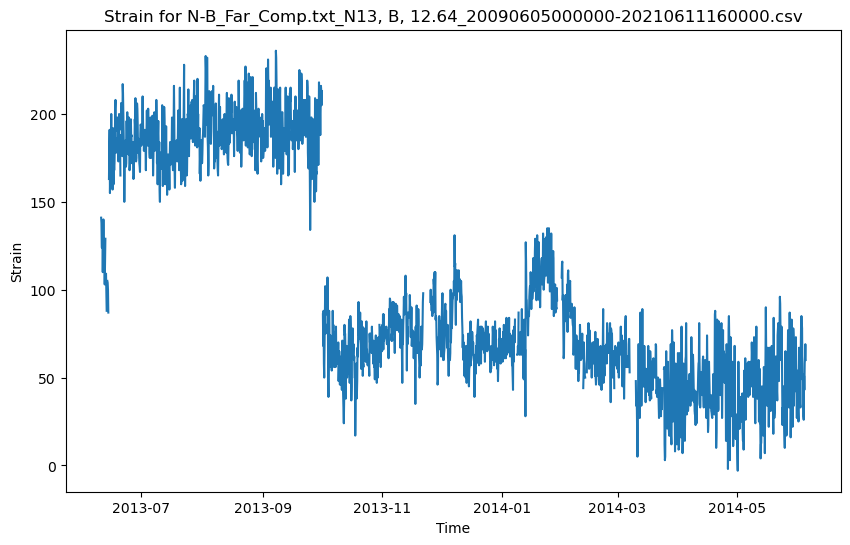

In [853]:
# Replace extreme outliers with NaN
df.loc[extreme_outlier_indices, 'Strain'] = np.nan  # Using np.nan to replace the outlier values
print(f'Number of outliers replaced with NaN: {len(extreme_outlier_indices)}')

plt.figure(figsize=(10, 6))
plt.plot(df['Time'], df['Strain'], linestyle='-')
plt.xlabel('Time')
plt.ylabel('Strain')
plt.title(f'Strain for {file}')
plt.show()

### Statistics

In [854]:
#Print the statistics of the data
df['Strain'].describe()

count    2070.000000
mean      103.740580
std        61.813208
min        -3.000000
25%        58.000000
50%        77.000000
75%       176.750000
max       236.000000
Name: Strain, dtype: float64

Text(0.5, 1.0, 'Box Plot of Strain')

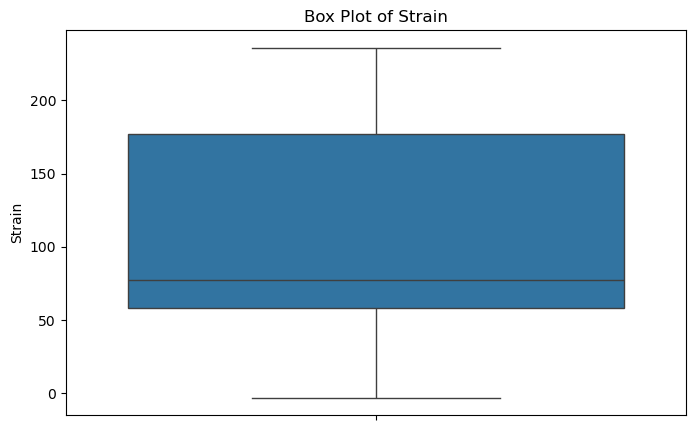

In [855]:
#Boxplot of strain values
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(y=df['Strain'])

plt.ylabel('Strain')
plt.title(f'Box Plot of Strain')

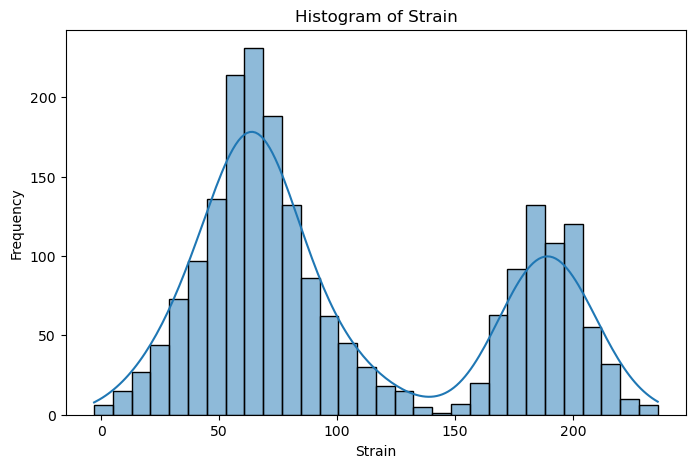

In [856]:
# Create a histogram
plt.figure(figsize=(8, 5))
sns.histplot(df['Strain'], bins=30, kde=True)  # kde=True adds a density curve

# Labels and title
plt.xlabel('Strain')
plt.ylabel('Frequency')
plt.title('Histogram of Strain')

# Show plot
plt.show()

### Missing values

In [857]:
#Count the number of NaN values in each column
df.isna().sum()

# Get the indices of NaN values in the 'Strain' column
nan_indices = df[df['Strain'].isna()].index.tolist()

nan_indices_with_time = pd.DataFrame({
    # 'Index': nan_indices,
    'Time': df.loc[nan_indices, 'Time']
})

nan_indices_with_time

,Time
7901,2013-06-10 08:00:00
7916,2013-06-12 20:00:00
7920,2013-06-13 12:00:00
7925,2013-06-14 08:00:00
7950,2013-06-18 12:00:00
...,...
9621,2014-03-24 00:00:00
9622,2014-03-24 04:00:00
9623,2014-03-24 08:00:00
9624,2014-03-24 12:00:00


Lenght: 21, Start Time: 2013-11-22 00:00:00, End Time: 2013-11-25 08:00:00
Lenght: 18, Start Time: 2014-03-07 08:00:00, End Time: 2014-03-10 04:00:00
Lenght: 13, Start Time: 2014-01-29 08:00:00, End Time: 2014-01-31 08:00:00
Lenght: 6, Start Time: 2014-01-07 20:00:00, End Time: 2014-01-08 16:00:00
Lenght: 4, Start Time: 2013-07-10 20:00:00, End Time: 2013-07-11 08:00:00
Lenght: 4, Start Time: 2014-02-12 16:00:00, End Time: 2014-02-13 04:00:00
Lenght: 4, Start Time: 2014-03-24 00:00:00, End Time: 2014-03-24 12:00:00
Lenght: 3, Start Time: 2013-10-03 08:00:00, End Time: 2013-10-03 16:00:00
Lenght: 2, Start Time: 2013-10-01 08:00:00, End Time: 2013-10-01 12:00:00
Lenght: 1, Start Time: 2013-06-10 08:00:00, End Time: 2013-06-10 08:00:00
Lenght: 1, Start Time: 2013-06-12 20:00:00, End Time: 2013-06-12 20:00:00
Lenght: 1, Start Time: 2013-06-13 12:00:00, End Time: 2013-06-13 12:00:00
Lenght: 1, Start Time: 2013-06-14 08:00:00, End Time: 2013-06-14 08:00:00
Lenght: 1, Start Time: 2013-06-18 1

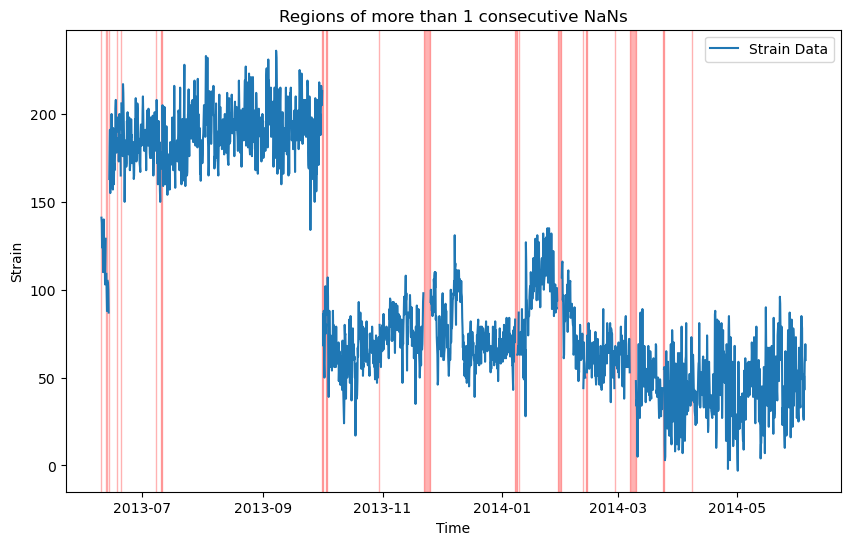

In [858]:
import nan_regions #nan_regions.py

thresholds = [1] # Choose the threshold(s) for consecutive NaNs

for threshold in thresholds:
    consecutive_nan_regions, nan_regions_sorted = nan_regions.find_nan_regions(df, threshold=1)
    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(df['Time'], df['Strain'], linestyle='-', label="Strain Data")

    # Shade regions with more than x consecutive NaNs
    for start, end in consecutive_nan_regions:
        plt.axvspan(df['Time'].loc[start], df['Time'].loc[end], color='red', alpha=0.3)

    # Labels and title
    plt.xlabel('Time')
    plt.ylabel('Strain')
    plt.title(f'Regions of more than {threshold} consecutive NaNs')
    plt.legend()
    
    for column in nan_regions_sorted:
        print(f"Lenght: {column[4]}, Start Time: {column[2]}, End Time: {column[3]}")
    plt.show()

### Availability of data

In [859]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import matplotlib.dates as mdates

# def heatmap(loops_to_keep):
#     # Read and process data
#     df = pd.read_csv('txt/filelist.txt', delimiter=',', header=None)
#     df.rename(columns={df.columns[0]: 'Date_path'}, inplace=True)
#     df['Datetime'] = pd.to_datetime(df['Date_path'], format='%Y%m%d%H%M%S')
#     df.rename(columns={df.columns[1]: 'Loop'}, inplace=True)
#     dates = df['Datetime'].unique()

#     loop_counts = df['Loop'].value_counts()
#     print(f'Number of channels: {len(loop_counts)}')

#     if loops_to_keep == 'all':
#         # Keep all rows if 'all' is selected
#         pass
#     elif isinstance(loops_to_keep, str) and loops_to_keep.endswith('.txt'):
#         # If it's a file path, read the loop names from the file
#         with open(loops_to_keep, 'r') as f:
#             loops_to_keep = [line.strip() for line in f.readlines()]  # Read and clean loop names
#         # Filter the DataFrame to only keep the rows with the loops in the 'loops_to_keep' list
#         df = df[df['Loop'].isin(loops_to_keep)]
#     else:
#         # If it's a list of loop names, use that list
#         df = df[df['Loop'].isin(loops_to_keep)]

#     # Create a boolean matrix using pivot_table()
#     boolean_matrix = df.pivot_table(index='Loop', columns='Datetime', aggfunc=lambda x: 1, fill_value=0)
#     boolean_matrix.columns = boolean_matrix.columns.droplevel(0)  # Drop the 'Date_path' level

#     # Plot heatmap with horizontal lines only
#     plt.figure(figsize=(160, 0.3*len(loops_to_keep)))
#     ax = sns.heatmap(boolean_matrix, cmap="Blues", cbar=False)

#     plt.title("Availability of Data Over Time")

#     # Ensure labels are not rotated
#     step = int(len(dates) / (len(dates)/30.5/6))
#     ax.set_xticks(range(235, len(dates), step))  # Set ticks at intervals (235 is when September begins so that the ticks are at the beginning of each month)
#     ax.set_xticklabels([dates[i].strftime('%Y-%m') for i in range(235, len(dates), step)], rotation=90, fontsize=30)

#     ax.hlines(y=[i + 1 for i in range(len(boolean_matrix))], xmin=0, xmax=len(boolean_matrix.columns), color='black', linewidth=0.5)

#     ax.set_yticklabels(boolean_matrix.index, rotation=0)

#     # Show plot
#     plt.show()


# # Define the option to read loops from a text file or specify 'all'
# # loops_to_keep = 'N-B_Far_Comp.txt'  # Option: 'all' or path to a text file (e.g., 'loops.txt')
# loops_to_keep = 'txt/comp_loops_notEI_filtered.txt'  # Option: 'all' or path to a text file (e.g., 'loops.txt')
# title = 'Heatmap'
# heatmap(loops_to_keep)

In [860]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import matplotlib.dates as mdates

# def heatmap(loops_to_keep):

#     # Ensure loops_to_keep is a list, even if it's a single string
#     if isinstance(loops_to_keep, str):
#         loops_to_keep = [loops_to_keep]

#     # Read and process data
#     df = pd.read_csv('txt/filelist.txt', delimiter=',', header=None)
#     df.rename(columns={df.columns[0]: 'Date_path'}, inplace=True)
#     df['Datetime'] = pd.to_datetime(df['Date_path'], format='%Y%m%d%H%M%S')
#     df.rename(columns={df.columns[1]: 'Loop'}, inplace=True)
#     dates = df['Datetime'].unique()

#     loop_counts = df['Loop'].value_counts()
#     print(f'Number of channels: {len(loop_counts)}')

#     print(type(loops_to_keep))

#     df = df[df['Loop'].isin(loops_to_keep)]

#     # Create a boolean matrix using pivot_table()
#     boolean_matrix = df.pivot_table(index='Loop', columns='Datetime', aggfunc=lambda x: 1, fill_value=0)
#     boolean_matrix.columns = boolean_matrix.columns.droplevel(0)  # Drop the 'Date_path' level

#     # Plot heatmap with horizontal lines only
#     plt.figure(figsize=(160, 0.3*len(loops_to_keep)))
#     ax = sns.heatmap(boolean_matrix, cmap="Blues", cbar=False)

#     plt.title("Availability of Data Over Time")

#     # Ensure labels are not rotated
#     step = int(len(dates) / (len(dates)/30.5/6))
#     ax.set_xticks(range(235, len(dates), step))  # Set ticks at intervals (235 is when September begins so that the ticks are at the beginning of each month)
#     ax.set_xticklabels([dates[i].strftime('%Y-%m') for i in range(235, len(dates), step)], rotation=90, fontsize=30)

#     ax.hlines(y=[i + 1 for i in range(len(boolean_matrix))], xmin=0, xmax=len(boolean_matrix.columns), color='black', linewidth=0.5)

#     ax.set_yticklabels(boolean_matrix.index, rotation=0)

#     # Show plot
#     plt.show()


# # Define the option to read loops from a text file or specify 'all'
# # Read the loop names from the .txt file before calling the function
# # with open('txt/comp_loops_notEI_filtered1.txt', 'r') as f:
# #     loops_to_keep = [line.strip() for line in f.readlines()]
# loops_to_keep = ['N-B_Far_Comp.txt', 'N-Klaff_Comp.txt']  # Option: 'all' or path to a text file (e.g., 'loops.txt')
# print(f'Loops to keep: {loops_to_keep}')
# heatmap(loops_to_keep)